- Prepare data
- Build Model
- Train
- Build evaluation matrix
- Evaluate

If use behaviour information alone, the predicted AUC is around 0.5, which means nothing is learnt.

In [1]:
import sys
sys.path.insert(0, "../scripts/")

In [27]:
import numpy as np

In [2]:
from dataset import *

## Load and prepare dataset

In [3]:
env = 'MINDsmall_train'
train_df = load_behavior_data(f'../data/{env}/behaviors.tsv')
train_df = behavior_to_user_item_pair_w_label(train_df)
train_df.shape

(5843444, 3)

In [4]:
env = 'MINDsmall_dev'
test_df = load_behavior_data(f'../data/{env}/behaviors.tsv')
test_df = behavior_to_user_item_pair_w_label(test_df)
test_df.shape

(2740998, 3)

## Modeling

#### Two tower structure, pair-wise matching

In [5]:
from sklearn import preprocessing

In [6]:
user_2_idx = preprocessing.LabelEncoder()
news_2_idx = preprocessing.LabelEncoder()

In [7]:
# fit label encoder
%time
user_2_idx.fit(train_df[USER_ID].values.tolist()+test_df[USER_ID].values.tolist())
news_2_idx.fit(train_df[NEWS_ID].values.tolist()+test_df[NEWS_ID].values.tolist())

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.34 µs


LabelEncoder()

Prepare train and test

In [12]:
X1 = user_2_idx.transform(train_df[USER_ID])
X2 = news_2_idx.transform(train_df[NEWS_ID])
Y = train_df[LABEL]

In [13]:
X1_test = user_2_idx.transform(test_df[USER_ID])
X2_test = news_2_idx.transform(test_df[NEWS_ID])
Y_test = test_df[LABEL]

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(X1, X2, Y, test_size=0.2, random_state=42)

In [14]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [15]:
USER_SIZE = len(user_2_idx.classes_)
NEWS_SIZE = len(news_2_idx.classes_)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L
from tensorflow import keras
# from keras import 

In [17]:
# define the layers
def create_model(embedding_dim=64):
    x_user = L.Input(shape=(1,))
    x_news = L.Input(shape=(1,))

    user_embedding = L.Embedding(input_dim=USER_SIZE, output_dim=embedding_dim)
    news_embedding = L.Embedding(input_dim=NEWS_SIZE, output_dim=embedding_dim)
    
    h1 = user_embedding(x_user)
    h2 = user_embedding(x_news)
    h = L.Concatenate()([h1,h2])
    y = L.Dense(1, activation='sigmoid')(h)
    y = L.Dot(axes=-1, normalize=False )([h1,h2])
    # define the model
    model = Model(inputs=[x_user,x_news], outputs=y)
    return model

In [18]:
tf.keras.backend.clear_session()

In [19]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 64)        6019648     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot (Dot)                       (None, 1, 1)         0           embedding[0][0]              

In [20]:
opt = tf.keras.optimizers.SGD(learning_rate=1e-3)

In [21]:
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [22]:
# model.compile(optimizer=opt, 
#     # Loss function to minimize
#     loss=keras.losses.BinaryCrossentropy(),
#     # List of metrics to monitor
#     metrics=['accuracy'])

In [23]:
model.fit([X1,X2], Y, epochs=10, batch_size=51200, validation_split=0.1)

Epoch 1/10
103/103 [==============================] - 2s 23ms/step - loss: 0.4282 - accuracy: 0.9596 - val_loss: 0.4282 - val_accuracy: 0.9596
Epoch 2/10
103/103 [==============================] - 2s 22ms/step - loss: 0.4279 - accuracy: 0.9596 - val_loss: 0.4282 - val_accuracy: 0.9596
Epoch 3/10
103/103 [==============================] - 2s 22ms/step - loss: 0.4277 - accuracy: 0.9596 - val_loss: 0.4282 - val_accuracy: 0.9596
Epoch 4/10
103/103 [==============================] - 2s 22ms/step - loss: 0.4276 - accuracy: 0.9596 - val_loss: 0.4282 - val_accuracy: 0.9596
Epoch 5/10
103/103 [==============================] - 2s 22ms/step - loss: 0.4275 - accuracy: 0.9596 - val_loss: 0.4282 - val_accuracy: 0.9596
Epoch 6/10
103/103 [==============================] - 2s 22ms/step - loss: 0.4274 - accuracy: 0.9596 - val_loss: 0.4282 - val_accuracy: 0.9596
Epoch 7/10
103/103 [==============================] - 2s 22ms/step - loss: 0.4273 - accuracy: 0.9596 - val_loss: 0.4282 - val_accuracy: 0.9596

In [34]:
model.fit([X1_train,X2_train], Y_train, epochs=10, batch_size=51200, validation_data=([X1_test, X2_test], Y_test))
          #validation_split=0.1)

Epoch 1/10
92/92 [==============================] - 2s 24ms/step - loss: 0.4275 - accuracy: 0.9595 - val_loss: 0.4309 - val_accuracy: 0.9594
Epoch 2/10
92/92 [==============================] - 2s 23ms/step - loss: 0.4275 - accuracy: 0.9595 - val_loss: 0.4309 - val_accuracy: 0.9594
Epoch 3/10
92/92 [==============================] - 2s 24ms/step - loss: 0.4274 - accuracy: 0.9595 - val_loss: 0.4309 - val_accuracy: 0.9594
Epoch 4/10
92/92 [==============================] - 2s 23ms/step - loss: 0.4273 - accuracy: 0.9595 - val_loss: 0.4309 - val_accuracy: 0.9594
Epoch 5/10
92/92 [==============================] - 2s 24ms/step - loss: 0.4273 - accuracy: 0.9595 - val_loss: 0.4309 - val_accuracy: 0.9594
Epoch 6/10
92/92 [==============================] - 2s 24ms/step - loss: 0.4272 - accuracy: 0.9595 - val_loss: 0.4309 - val_accuracy: 0.9594
Epoch 7/10
92/92 [==============================] - 2s 23ms/step - loss: 0.4272 - accuracy: 0.9595 - val_loss: 0.4309 - val_accuracy: 0.9594
Epoch 8/10
92

In [24]:
from sklearn import metrics

In [25]:
y_pred = model.predict([X1_test, X2_test])

In [28]:
y_pred = np.squeeze(y_pred)

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred)

In [31]:
metrics.auc(fpr, tpr)

0.49974843095975247

In [32]:
from matplotlib import pyplot as plt
%matplotlib inline

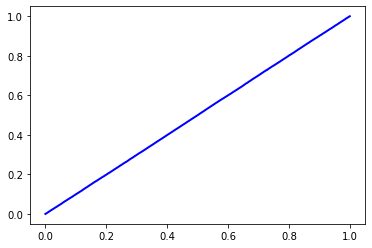

In [33]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='b', lw=2)
plt.show()